# Elastic Reverse Time Adjoint Migration (E-RTAM) using a compact formulation 

In this tutorial, we perform an E-RTAM using compact forward and adjoint modeling equations. These equations are based on the stiffness matrix (${\bf C}$) and the ${\bf D}$ and ${\bf S}$ matrices representing the differential operators.

## Forward modeling

The propagation of seismic waves in heterogeneous, isotropic, elastic earth media can be expressed by the elastodynamic equations:

\begin{equation}
\left\{\begin{array}{ll} 
\dfrac{\partial \sigma_{xx}}{\partial t} - (\lambda+2\mu)\dfrac{\partial v_{x}}{\partial x}-\lambda\dfrac{\partial v_{z}}{\partial z}=f_{\sigma_{xx}},\\
\dfrac{\partial\sigma_{zz}}{\partial t}-(\lambda+2\mu)\dfrac{\partial v_{z}}{\partial z} -\lambda\dfrac{\partial v_{x}}{\partial x}=f_{\sigma_{zz}},\\
\dfrac{\partial \sigma_{zx}}{\partial t} -\mu\Big(\dfrac{\partial v_{x}}{\partial z} + \dfrac{\partial v_{z}}{\partial x}\Big) = f_{\sigma_{zx}},\\
\rho\dfrac{\partial v_x}{\partial t} - \Big(\dfrac{\partial \sigma_{xx}}{\partial x} + \dfrac{\partial \sigma_{xz}}{\partial z} )=0,\\
\rho\dfrac{\partial v_z}{\partial t} - \Big(\dfrac{\partial \sigma_{zx}}{\partial x}+\dfrac{\partial \sigma_{zz}}{\partial z}\Big)=0 .
\end{array}\right.
\end{equation}


where $\vec{v}=(v_x,~v_z)$ are the horizontal and vertical particle velocity fields, $\sigma=(\sigma_{xx},~\sigma_{zz},~\sigma_{xz}$) are the stress fields, $f=$($f_{\sigma_{xx}},~f_{\sigma_{xx}})$
are the source terms, $\rho$ is density, $\lambda$ and $\mu$ are the Lame parameters. The elastic wave equation given described above can be organized using a compact formulation as presented by Chen and Sacchi (2020):

\begin{equation}
     \left\{\begin{array}{l}\rho \dfrac{\partial \vec{v}}{\partial t}-{\bf D} \sigma=0,\\ 
     \dfrac{\partial \sigma}{\partial t}-{\bf C D}^{T} \vec{v}=f_\sigma, \end{array}\right.
\end{equation}

being ${\bf C}$ the isotropic elastic tensor in Voigt notation, ${\bf D}$ is a collection of spatial differential operators, defined as

\begin{equation}
\begin{split}
   {\bf C}=\left(\begin{array}{ccc}
   \lambda+2 \mu & \lambda & 0 \\
   \lambda & \lambda+2 \mu & 0 \\ 
   0 & 0 & \mu \end{array}\right)~~\text{e}~~
{\bf D}=\left(\begin{array}{ccc}  
\dfrac{\partial}{\partial x}& 0 &\dfrac{\partial}{\partial z} \\
0 &  \dfrac{\partial}{\partial z}&\dfrac{\partial}{\partial x}
\end{array}\right)  .
\end{split}
\end{equation}

In our compact formulation, the stress tensor $(\sigma)$ is represented is written in vectorial form:

\begin{equation}
\sigma=\left(\begin{array}{c}
 \sigma_{xx}  \\ 
 \sigma_{zz}  \\ 
 \sigma_{zx}
\end{array}\right)
\end{equation}

The conversion from matrix to vector form of the stress tensor is done using the vec() function. An example of this application is $\sigma$=vec($\sigma$).

In [1]:
from examples.seismic.source import RickerSource, TimeAxis
from examples.seismic import setup_geometry, PointSource, Receiver
from examples.seismic import SeismicModel
from examples.seismic.stiffness.model import ElasticModel
from examples.seismic.stiffness.utils import C_Matrix, D, S, vec
from devito import (Eq, Operator, VectorTimeFunction, TensorTimeFunction,
                    VectorFunction, solve)
from examples.seismic.stiffness import iso_elastic_setup
import numpy as np
import matplotlib.pyplot as plt
from devito import configuration, norm
configuration['log-level'] = 'WARNING'

In [2]:
nx = 200
nz = 120

shape = (nx, nz)
spacing = (10., 10.)
origin = (0., 0.)
nlayers = 3
nbl = 50
space_order = 8
dtype = np.float32

# Model physical parameters:
vp = np.empty(shape, dtype=dtype)
vs = np.empty(shape, dtype=dtype)
rho = np.empty(shape, dtype=dtype)
b = np.empty(shape, dtype=dtype)

# Define a velocity profile. The velocity is in km/s
vp_top = 1.5
vp_bottom = 3.5
# define a velocity profile in km/s
v = np.empty(shape, dtype=dtype)
v[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, nlayers)
for i in range(1, nlayers):
    v[..., i*int(shape[-1] / nlayers):] = vp_i[i]  # Bottom velocity

vs[:] = 0.5 * v[:]
vs[v < 1.51] = 0.0


rho[:] = 0.31*(v[:]*1000.)**0.25  # Gardner's relation

In [3]:
model=ElasticModel(vp=v, vs=vs, rho=rho, origin=origin, space_order=space_order,
                     shape=shape, dtype=dtype, spacing=spacing, nbl=nbl)

In [4]:
# function to plot P wave velocity, S wave velocity and density models
def img_model(img1, img2, img3, model, title=""):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title("Vs (km/s)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$\rho$ ($g/cm^3$)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

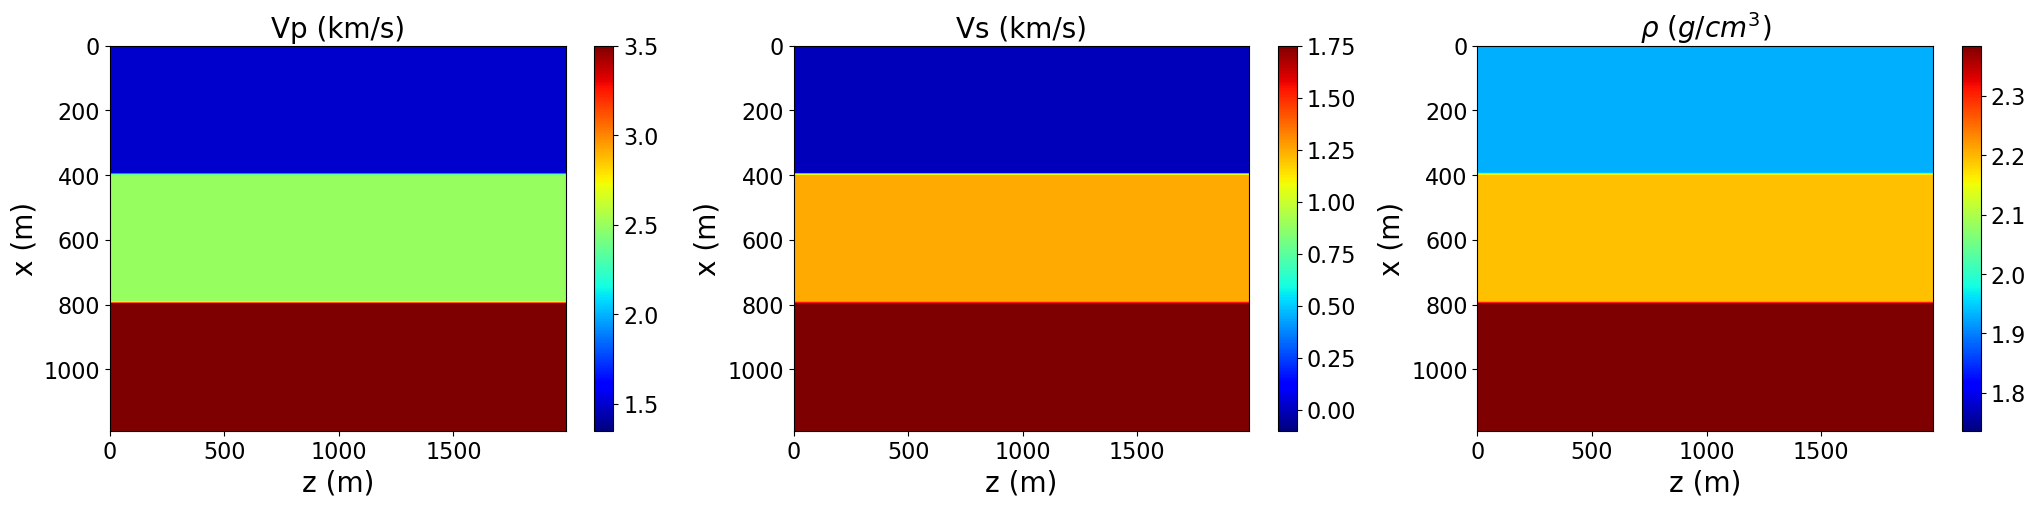

In [5]:
img_model(v, vs, rho, model)

In [6]:
f0 = 0.020  # peak/dominant frequency
rho = model.rho

s = model.grid.stepping_dim.spacing
damp = model.damp

# Time step in ms and time range:
t0, tn = 0., 1800.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

geometry = setup_geometry(model, tn, f0=f0)

In [7]:
# Function that define source and receiver parameters
def source_rec_term(model, sigma, v0, pos):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
    src.coordinates.data[0, :] = pos[0]  # position of source in offset
    src.coordinates.data[0, -1] = pos[1]  # position of source in depth

    # Create symbol for receivers
    rec_vx = Receiver(name='rec_vx', grid=model.grid, npoint=shape[0],
                      time_range=time_range)
    rec_vz = Receiver(name='rec_vz', grid=model.grid, npoint=shape[0],
                      time_range=time_range)
    rec_sigma = Receiver(name='rec_sigma', grid=model.grid, npoint=shape[0],
                         time_range=time_range)

    # Prescribe even spacing for receivers along the x-axis
    rec_vx.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec_vx.coordinates.data[:, 1] = 400.  # postion of receiver at 400 m depth for vx

    rec_vz.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    rec_vz.coordinates.data[:, 1] = 400.  # postion of receiver at 400 m depth for vz

    rec_sigma.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=shape[0])
    # postion of receiver at 10 m of depth for pressure field
    rec_sigma.coordinates.data[:, 1] = 10.

    src_xx = src.inject(field=sigma[0].forward, expr=src * s)
    src_zz = src.inject(field=sigma[1].forward, expr=src * s)
    src_term = src_xx + src_zz

    rec_term_vx = rec_vx.interpolate(expr=v0[0])
    rec_term_vz = rec_vz.interpolate(expr=v0[1])
    rec_expr = rec_term_vx + rec_term_vz

    expr = sigma[0] + sigma[1]
    rec_term_sigma = rec_sigma.interpolate(expr=expr)
    rec_expr += rec_term_sigma

    return rec_vx, rec_vz, rec_sigma, rec_expr, src_term, src

In [8]:
# Creating the isotropic elastic tensor
C = C_Matrix(model,'Ip-Is-rho')
C

Matrix([
[                      Ip(x, y)*vp(x, y), Ip(x, y)*vp(x, y) - 2*Is(x, y)*vs(x, y),                 0],
[Ip(x, y)*vp(x, y) - 2*Is(x, y)*vs(x, y),                       Ip(x, y)*vp(x, y),                 0],
[                                      0,                                       0, Is(x, y)*vs(x, y)]])

## Building the forward  operator

The **elastic_forward(...)** function is responsible for forward modeling and makes use of the compact first-order elastic  equation system described below:

\begin{equation}
     \left\{\begin{array}{l}\rho \dfrac{\partial \vec{v}}{\partial t}-D \sigma=0,\\ 
     \dfrac{\partial \sigma}{\partial t}-C D^{T} \vec{v}=f_\sigma, \end{array}\right.
\end{equation}


In [9]:
def elastic_forward(model, pos, **kwargs):

    v0 = VectorTimeFunction(name='v0', grid=model.grid, save=geometry.nt, time_order=1,
                            space_order=space_order)
    sigma = TensorTimeFunction(name='sigma', grid=model.grid, space_order=space_order,
                               save=geometry.nt, time_order=1)
    sigma = vec(sigma)

    pde_v = rho * v0.dt - D(sigma)
    u_v = Eq(v0.forward, damp * solve(pde_v, v0.forward))

    pde_sigma = sigma.dt - C * S(v0.forward)
    u_sigma = Eq(sigma.forward, damp * solve(pde_sigma, sigma.forward))

    rec_vx, rec_vz, rec_sigma, rec_expr, src_term, src = source_rec_term(model, sigma,
                                                                         v0, pos)

    op = Operator([u_v, u_sigma] + src_term + rec_expr, subs=model.spacing_map)
    op(dt=dt, src=src, rec_vx=rec_vx, rec_vz=rec_vz, rec_sigma=rec_sigma, vp=model.vp, vs=model.vs, Ip=model.Ip, Is=model.Is, rho=model.rho)
    
    return rec_vx, rec_vz, rec_sigma, v0, sigma

In [10]:
# generating a shot with the source in the center of the model

pos = np.empty((1, 2), dtype=np.float32)
pos[0, 0] = model.domain_size[0] * .5

rec_vx, rec_vz, rec_sigma, v, sigma = elastic_forward(model, pos[0])


## Plotting vx, vz and pressure fields shots

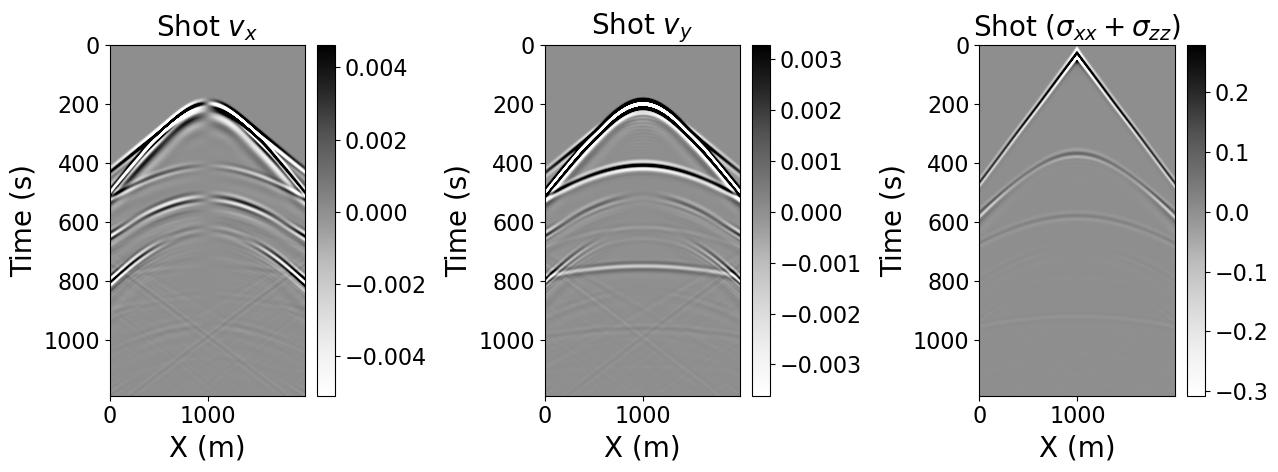

In [11]:
# NBVAL_IGNORE_OUTPUT
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

aspect_ratio = model.shape[0]/model.shape[1]

plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0] +
                                                 model.domain_size[0],
                                                 model.origin[1] +
                                                 model.domain_size[1],
                                                 model.origin[1]]}
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

scale = np.max(rec_vx.data) / 10.

img1 = ax[0].imshow(rec_vx.data, vmin=scale, vmax=-scale, **plt_options_model)
fig.colorbar(img1, ax=ax[0])
ax[0].set_title(r"Shot $v_x$", fontsize=20)
ax[0].set_xlabel('X (m)', fontsize=20)
ax[0].set_ylabel('Time (s)', fontsize=20)
ax[0].set_aspect('auto')

scale2 = np.max(rec_vz.data) / 10.
img2 = ax[1].imshow(rec_vz.data, vmin=scale2, vmax=-scale2, **plt_options_model)
fig.colorbar(img2, ax=ax[1])
ax[1].set_title("Shot $v_y$", fontsize=20)
ax[1].set_xlabel('X (m)', fontsize=20)
ax[1].set_ylabel('Time (s)', fontsize=20)
ax[1].set_aspect('auto')

scale3 = np.max(rec_sigma.data) / 10.
img3 = ax[2].imshow(rec_sigma.data, vmin=scale3, vmax=-scale3, **plt_options_model)
fig.colorbar(img3, ax=ax[2])
ax[2].set_title(r"Shot ($\sigma_{xx}+\sigma_{zz}$)", fontsize=20)
ax[2].set_xlabel('X (m)', fontsize=20)
ax[2].set_ylabel('Time (s)', fontsize=20)
ax[2].set_aspect('auto')

plt.tight_layout()

## Plotting the wavefields snapshots for the particle velocity vector and the stress tensor components

<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6908/739656560.py:37: SyntaxWarning: invalid escape sequence '\s'
  plot(sigma[0], title="Snapshots $\sigma_{xx}$")
/tmp/ipykernel_6908/739656560.py:38: SyntaxWarning: invalid escape sequence '\s'
  plot(sigma[1], title="Snapshots $\sigma_{zz}$")
/tmp/ipykernel_6908/739656560.py:39: SyntaxWarning: invalid escape sequence '\s'
  plot(sigma[2], title="Snapshots $\sigma_{xz}$")


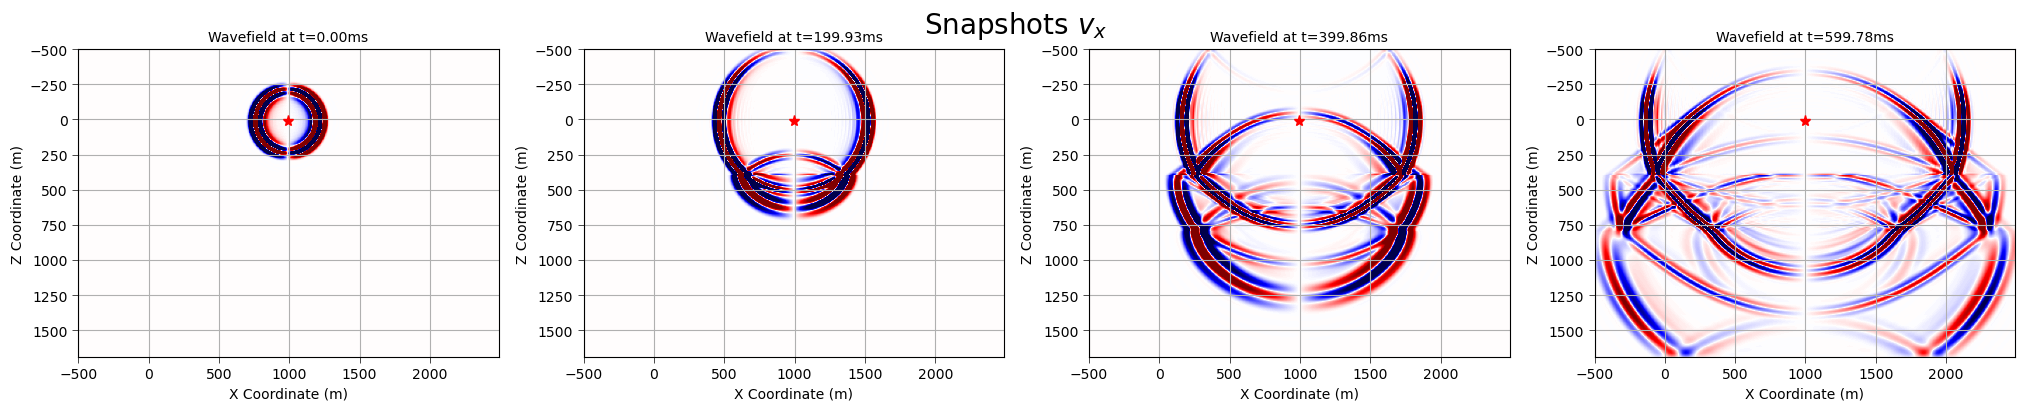

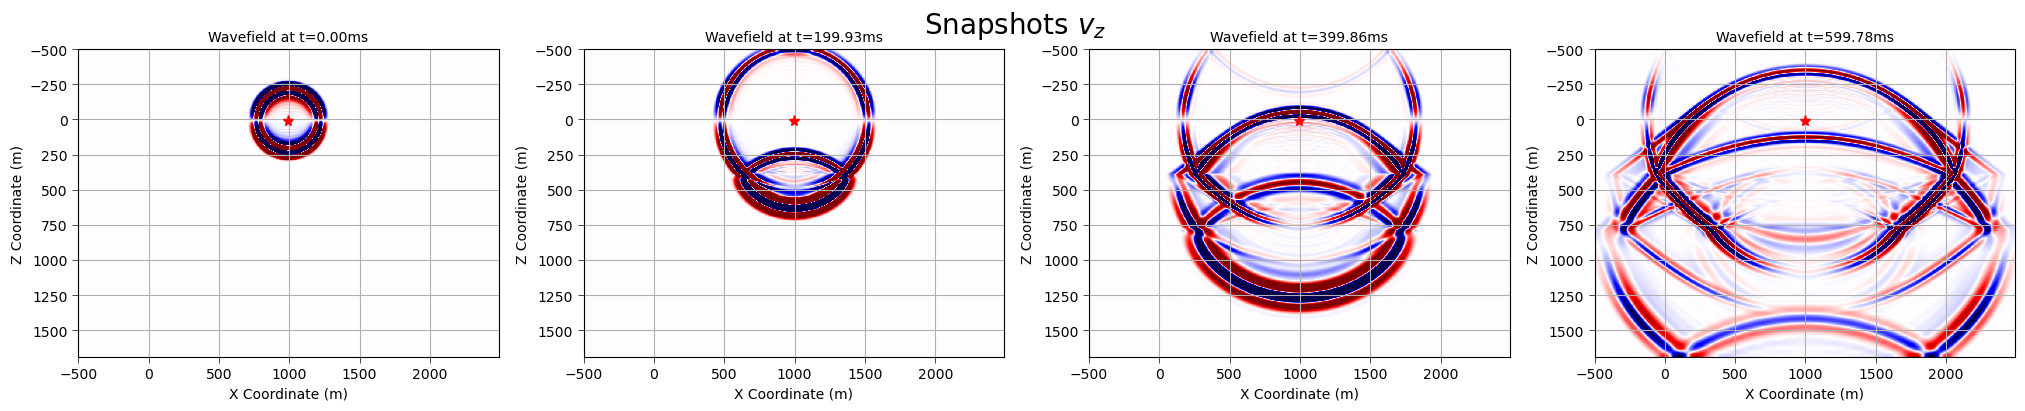

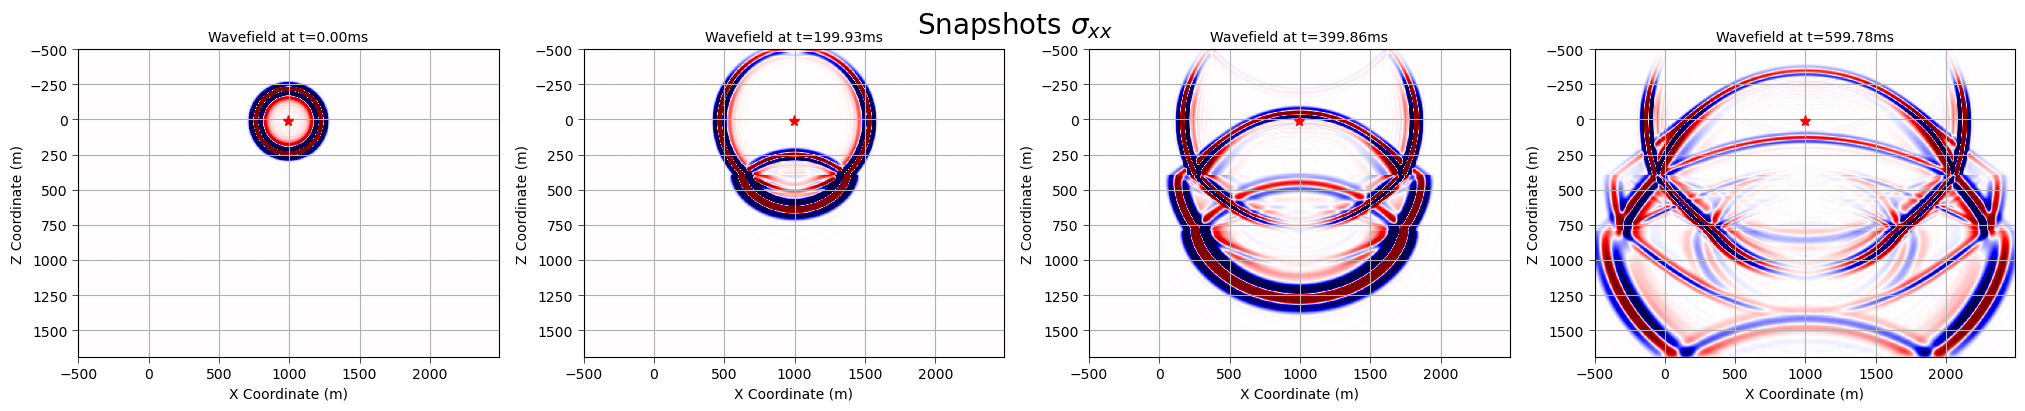

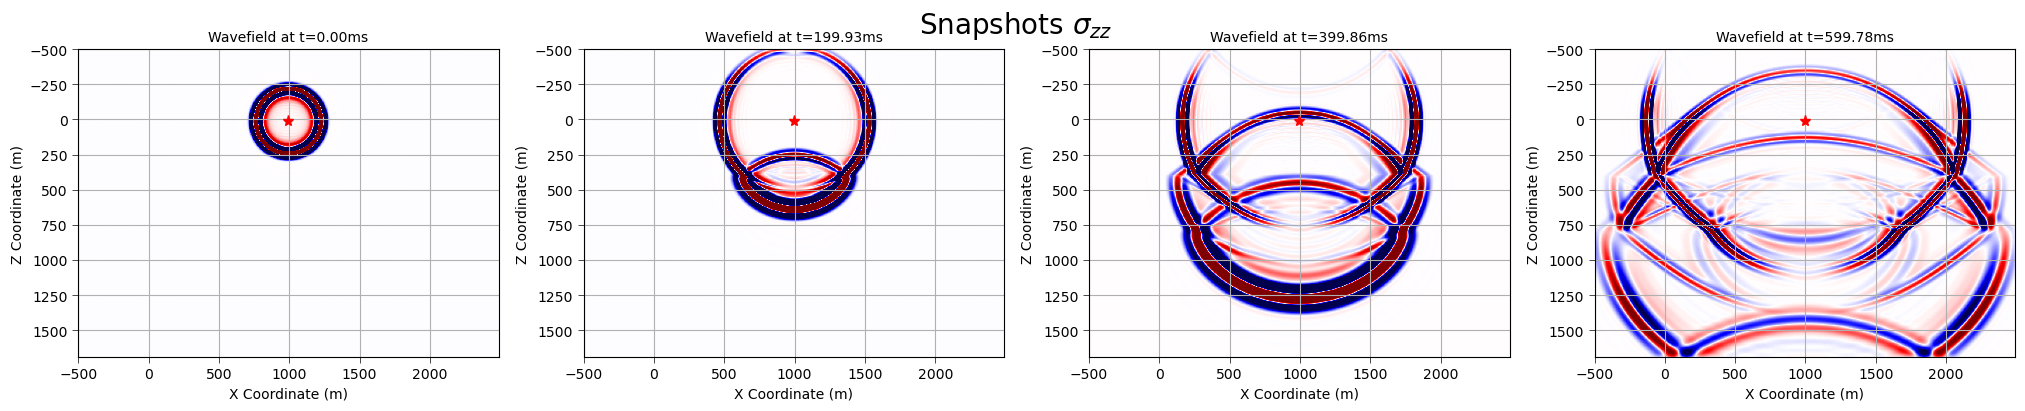

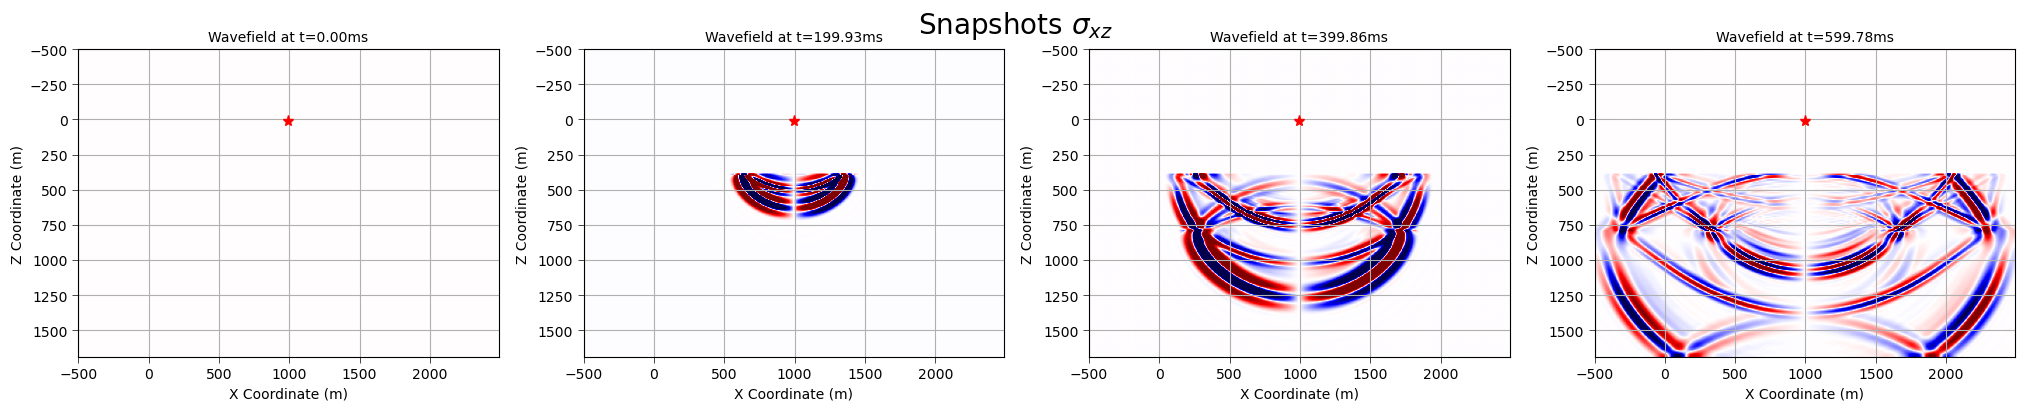

In [12]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
nxpad, nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
shape_pad = np.array(shape) + 2 * nbl
origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]


def plot(a, title=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(np.abs(a.data[kt, :, :]))

    nsnaps = 9
    factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=20)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(model.domain_size[0] * .5, 10, 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)


plot(v[0], title="Snapshots $v_x$")
plot(v[1], title="Snapshots $v_z$")
plot(sigma[0], title="Snapshots $\sigma_{xx}$")
plot(sigma[1], title="Snapshots $\sigma_{zz}$")
plot(sigma[2], title="Snapshots $\sigma_{xz}$")

# The elastic adjoint equation using a compact formulation

The adjoint operator is constructed from the compact system of elastic wave equations using the adjoint-state method (Feng and Schuster, 2017). From the elastic forward equation

\begin{equation}
     \left\{\begin{array}{l}\rho \dfrac{\partial \vec{v}}{\partial t}-{\bf D} \sigma=0,\\ 
     \dfrac{\partial \sigma}{\partial t}-{\bf C D}^{T} \vec{v}=f_\sigma, \end{array}\right.
\end{equation}

Writing in matrix format:

\begin{equation}
\left[ \begin{array}{cc}\rho \dfrac{\partial}{\partial t} & - {\bf D} \\
    -{\bf C D}^{T} & \dfrac{\partial}{\partial t}\end{array}\right] \left[\begin{array}{l}\vec{v} \\ \sigma\end{array}\right]=\left[\begin{array}{c}0 \\ \vec{f}_\sigma\end{array}\right],
\end{equation}

being

\begin{equation}
{\bf S}=\left [ \begin{array}{cc}\rho \dfrac{\partial}{\partial t} & -{\bf D} \\ -{\bf C D}^{T} & \dfrac{\partial}{\partial t}\end{array}\right],
~W=\left[\begin{array}{l}\vec{v} \\ \sigma\end{array}\right]~\text{and}~
f=\left[\begin{array}{c}0 \\ \vec{f}_\sigma\end{array}\right],
\end{equation}

rewriting as

\begin{equation}
    {\bf SW=f}.
\end{equation}

Solving by the adjoint method, we have the following system:

\begin{equation}
    {\bf S^*W^*=f^*},
\end{equation}

where * denotes the adjoint, the adjoint matrix $S$ becomes $S^*$, $W^*$ is the adjoint state variable vector containing the particle velocity fields $\vec{u}=(u_{x}, u_{z})$ and the adjoint stress tensors ($\tau$). $∆\vec{d} = G(\vec{m}) − \vec{d}$ is the residuals vector which in the context of E-RTM is $∆\vec{d} = −\vec{d} $, where $\vec{d}$ is the observed data,

\begin{equation}
{\bf S}^*= \left[\begin{array}{cc}-\rho \dfrac{\partial}{\partial t} & {\bf D C}^{T} \\ {\bf D}^{T} & -\dfrac{\partial}{\partial t}\end{array}\right],~        
{\bf W}^*=   \left[\begin{array}{c}\vec{u} \\ \tau\end{array}\right]       ~\text{and} ~    
{\bf f}^*= \left[\begin{array}{c}0 \\ \Delta \vec{d}\end{array}\right].
\end{equation}

Thus, matrix system is given by: 

\begin{equation}
    \left[\begin{array}{cc}-\rho \dfrac{\partial}{\partial t} & {\bf D C}^{T} \\ {\bf D}^{T} & -\dfrac{\partial}{\partial t}\end{array}\right] \left[\begin{array}{c}\vec{u} \\ \tau\end{array}\right]=\left[\begin{array}{c}0 \\ \Delta \vec{d}\end{array}\right],
\end{equation}

and, finally we have the compact elastic adjoint equation 

\begin{array}{l}\rho \dfrac{\partial \vec{u}}{\partial t}-{\bf D C}^{T} \tau=0\\
    {\bf D}^{T} \vec{u}-\dfrac{\partial \tau}{\partial t}=\Delta\overrightarrow{d}\end{array}

The `elastic_adjoint()` function generates the adjoint equations to be used in the RTM. In this function ${\bf S}$ correspond to ${\bf D}^T$. 

In [13]:
def elastic_adjoint(u, tau):
    pde_u = rho * u.dtl - D(C.T * tau)
    u_u = Eq(u.backward, damp * solve(pde_u, u.backward))

    pde_tau = -tau.dtl + S(u.backward)
    u_t = Eq(tau.backward, damp * solve(pde_tau, tau.backward))

    return [u_u, u_t]

## Imaging condition

We use a source-normalized crosscorrelation imaging conditions for 2D images of the particle-velocity wavefields,
for a common-source gather, which can be formulated mathematically as:

\begin{equation}
I_{xx}(x,z)=\frac{\int^t_0 v_x(x,z,t)u_x(x,z,t)dt}{\int^t_0 v^2_x(x,z,t)dt}
\end{equation}

and

\begin{equation}
I_{zz}(x,z)=\frac{\int^t_0 v_z(x,z,t)u_z(x,z,t)dt}{\int^t_0 v^2_z(x,z,t)dt}
\end{equation}

where $I_{xx}$ and $I_{zz}$ represent the horizontal and vertical image components, respectively.

In [18]:
def ImagingOperator(model, imf, v, **kwargs):

    u = VectorTimeFunction(name='u', grid=model.grid, space_order=space_order,
                           time_order=1)
    tau = TensorTimeFunction(name='tau', grid=model.grid, space_order=space_order,
                             time_order=1)
    tau = vec(tau)

    eqn = elastic_adjoint(u, tau)

    b = 1/rho
    # Define residual injection at the location of the forward receivers
    rec_vx = PointSource(name='rec_vx', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    rec_vz = PointSource(name='rec_vz', grid=model.grid,
                         time_range=geometry.time_axis,
                         coordinates=geometry.rec_positions)

    H = VectorFunction(name="H", grid=model.grid)

    Hx_sum = [Eq(H[0], H[0] + (v[0]**2))]
    Hz_sum = [Eq(H[-1], H[-1] + (v[-1]**2))]
    H_sum = Hx_sum + Hz_sum

    rec_term_vx = rec_vx.inject(field=u[0].backward, expr=dt*rec_vx*b)
    rec_term_vz = rec_vz.inject(field=u[-1].backward, expr=dt*rec_vz*b)

    rec_expr = rec_term_vx + rec_term_vz

    ixx_update = [Eq(imf[0], imf[0] + (v[0] * u[0])/(H[0] + 10**(-9)))]
    izz_update = [Eq(imf[-1], imf[-1] + (v[-1] * u[-1])/(H[-1] + 10**(-9)))]

    imf_update = ixx_update + izz_update

    return Operator(eqn + rec_expr + H_sum + imf_update, subs=model.spacing_map,
                    name='Imaging')

# Applying the E-RTAM for 10 shots

The `img_final(...)` function is responsible for making the E-RTAM and the sum of the images of each shot, thus generating the final image.

In [19]:
nshots = 10
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.shape[0]*model.spacing[0],
                                     num=nshots)
source_locations[:, 1] = 10.


def img_final(model):
    imf = VectorFunction(name="imf", grid=model.grid, space_order=8)

    for i in range(nshots):
        print('Imaging source %d out of %d' % (i+1, nshots))
        pos = source_locations[i, :]
        rec_vx, rec_vz, rec_sigma, v, sigma = elastic_forward(model, pos)

        op_imaging = ImagingOperator(model, imf, v)
        op_imaging(dt=dt, rec_vx=rec_vx, rec_vz=rec_vz)

    return imf

In [20]:
imf_adj = img_final(model)

Imaging source 1 out of 10
Imaging source 2 out of 10
Imaging source 3 out of 10
Imaging source 4 out of 10
Imaging source 5 out of 10
Imaging source 6 out of 10
Imaging source 7 out of 10
Imaging source 8 out of 10
Imaging source 9 out of 10
Imaging source 10 out of 10


In [21]:
# Plotting for final image
def img(img, model, title=""):

    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

    plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0]
                                                     + model.domain_size[0],
                                                     model.origin[1] +
                                                     model.domain_size[1],
                                                     model.origin[1]]}
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    scale = np.max(img[0].data[slices])

    img1 = ax[0].imshow(np.transpose(img[0].data[slices]), vmin=scale, vmax=-scale,
                        **plt_options_model)
    fig.colorbar(img1, ax=ax[0])
    ax[0].set_title(title + "$I_{xx}$", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale2 = np.max(img[1].data[slices])

    img2 = ax[1].imshow(np.transpose(img[1].data[slices]), vmin=scale2, vmax=-scale2,
                        **plt_options_model)
    fig.colorbar(img2, ax=ax[1])
    ax[1].set_title(title + "$I_{zz}$", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')
    plt.savefig('Elastic' + title + '.pdf')

In [22]:
def lapla(model, image):
    lapla = VectorFunction(name='lapla', grid=model.grid, space_order=8)
    stencil = Eq(lapla, -image.laplace)
    op = Operator([stencil])
    op.apply()
    return lapla

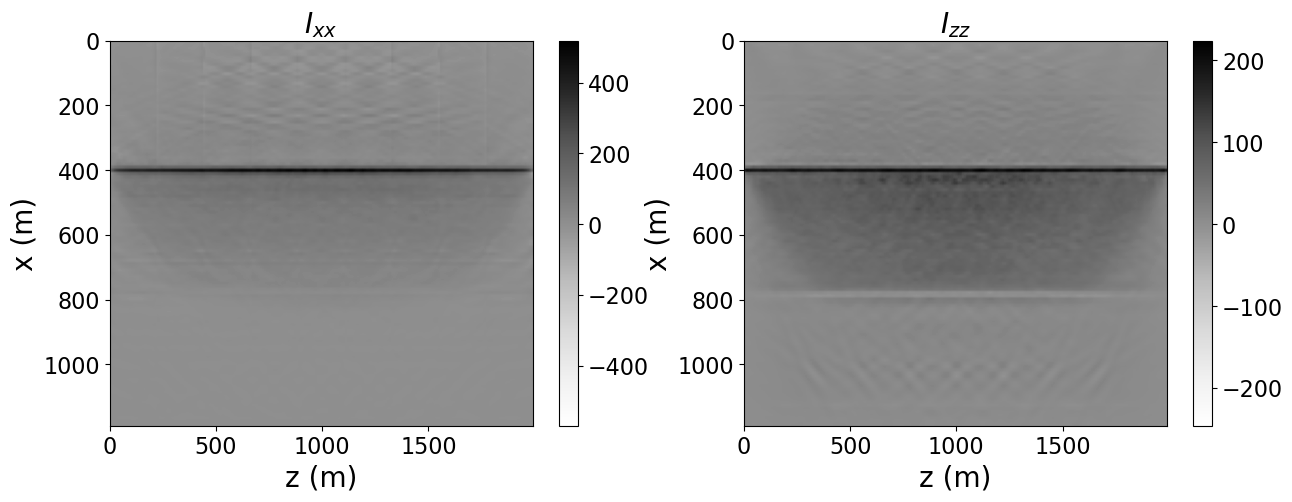

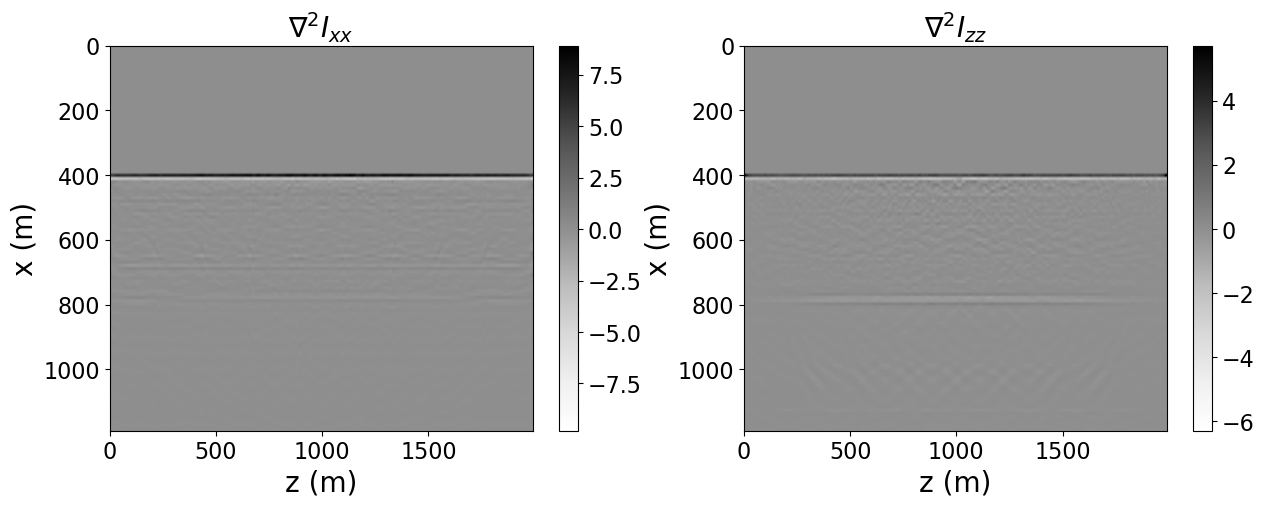

In [23]:
# Applying laplacian filter
image_final_adj = lapla(model, imf_adj)

# Doing zero the water layer

image_final_adj[0].data[:, :90] = 0.
image_final_adj[1].data[:, :90] = 0.

img(imf_adj, model, title="")
img(image_final_adj, model, title="$\\nabla^2$")

## Adjoint test

The adjoint $A^{*}$ of an operator $A$ has the property:

\begin{equation}
<Ax,~y>=<x,~A^*y>
\end{equation}

where $x$ is the forward wavefield and $y$ is the adjoint wavefield.

In [24]:
tn = 500.  # Final time

presets = {
    'layers-elastic': {'preset': 'layers-elastic', 'nlayers': 2},
}
# Create solver from preset
solver = iso_elastic_setup(shape=(20, 25), spacing=[15. for _ in shape], kernel=None,
                           nbl=10, tn=tn, space_order=2, time_order=1,
                           **(presets['layers-elastic']), dtype=np.float64)

# Create adjoint receiver symbol
srca = Receiver(name='srca', grid=solver.model.grid,
                time_range=solver.geometry.time_axis,
                coordinates=solver.geometry.src_positions)

# Run forward and adjoint operators
rec = solver.forward(save=False)[0]
solver.adjoint(rec=rec, srca=srca)

# Adjoint test: Verify <Ax,y> matches  <x, A^Ty> closely
term1 = np.dot(srca.data.reshape(-1), solver.geometry.src.data)
term2 = norm(rec) ** 2
print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
      % (term1, term2, (term1 - term2)/term1, term1/term2))


assert np.isclose((term1 - term2)/term1, 0., atol=1.e-11)

<x, A*y>: 741.008209, <Ax,y>: 741.008209, difference: -1.5342e-16, ratio: 1.000000


/tmp/ipykernel_6908/376251902.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'


# References

<br>[1] **Time-domain elastic Gauss–Newton full-waveform inversion:
a matrix-free approach** (2020)
<br>Ke Chen and Mauricio D. Sacchi
<br>Geophysical Journal International
<br> https://doi.org/10.1093/gji/ggaa330


<br>[2] **Elastic least-squares reverse time migration** (2017)
<br>Zongcai Feng and Gerard T. Schuster
<br>GEOPHYSICS Technical Papers 
<br>https://doi.org/10.1190/geo2016-0254.1